# Accessing GBIF Parquet data from AWS using duckdb

In [1]:
import duckdb

In [2]:
# create a connection and install extension for remote filesystems
con = duckdb.connect()
con.execute("INSTALL httpfs")
con.execute("LOAD httpfs")

Let's count up species diversity across the data. As observations can be reported as longitude/latitude pairs at arbitrary precision, we can round them off to the nearest degree (or tenth of a degree, etc). This provides a convenient mechanism for aggregating occurances into grid cells. To simplify the counting process, I will aggregate to genus (avoids a few synonyms, sub-species, and incomplete names).  For now, let's also just look at veterbrates, where maybe we have some chance that sampling is closer to saturation of local diversity and we're not just looking purely at sampling effort.  (That's still a bad assumption I think we'll see).  This is easy to express in SQL

GBIF data is available in parquet partitions from the [AWS Open Data Registry](https://registry.opendata.aws/gbif/).  We use the most recent monthly snapshot, corresponding to the S3 bucket, `s3://gbif-open-data-us-east-1/occurrence/2023-02-01/occurrence.parquet/`.  `duckdb` can execute arbitrary SQL queries against this remote data source without having to first download a local copy of the data, which is around a few hundred GB at present.

In [3]:
query = f'''
SELECT "class", longitude, latitude, COALESCE(n, 0.0) AS n
FROM (
  SELECT "class", longitude, latitude, COUNT(*) AS n
  FROM (
    SELECT DISTINCT
      "class",
      genus,
      ROUND(decimallongitude, CAST(ROUND(0.0, 0) AS INTEGER)) AS longitude,
      ROUND(decimallatitude, CAST(ROUND(0.0, 0) AS INTEGER)) AS latitude
    FROM read_parquet("s3://gbif-open-data-us-east-1/occurrence/2023-02-01/occurrence.parquet/*")
    WHERE (phylum = 'Chordata')
  )
  GROUP BY "class", longitude, latitude
)
'''

res = con.execute(query)
df = res.df()


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

Some more detailed quality checks are definitely necessary here -- inaccurate spatial information in particular can be hugely distorting (such as museum specimens that may be tagged to the coordinates of the museum rather than their original place of origin).  Also, it is typical to use an observation model to compute likely true species richness given the observations, though with the highly varied sources and lack of effort data this is difficult (though we could imagine quite a few proxies, such as comparing to overall GBIF sampling density).  These issues are beyond our scope for the moment, which is to demonstrate a relatively simple/transparent workflow for processing the full data from the latest upstream sources.

To avoid a few oversampled locations dominating the counts I'll transform to log counts (obviously could have been done as part of our query), and focus in on a particular taxonomic Class (e.g. Amphibians).  

It would be more interesting to compare this to other data sources, such as [MoBI](https://planetarycomputer.microsoft.com/dataset/mobi) or IUCN redlist data, etc.

In [14]:
import numpy as np
taxa = df[df["class"] == "Mammalia"]
taxa = taxa.assign(logn = np.log(taxa.n.values))
taxa


,class,longitude,latitude,n,logn
154,Mammalia,-149.0,64.0,34.0,3.526361
158,Mammalia,16.0,39.0,27.0,3.295837
163,Mammalia,-92.0,36.0,40.0,3.688879
165,Mammalia,-6.0,32.0,30.0,3.401197
171,Mammalia,79.0,27.0,18.0,2.890372
...,...,...,...,...,...
170600,Mammalia,-132.0,-68.0,1.0,0.000000
170606,Mammalia,-1.0,-48.0,1.0,0.000000
170609,Mammalia,125.0,-60.0,1.0,0.000000
170611,Mammalia,-174.0,44.0,1.0,0.000000


In [15]:
# 

import geopandas as gpd
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial

def cube(df):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs='epsg:4326')
    geo_grid = make_geocube(
        vector_data=gdf,
        measurements=['logn'],
        resolution=1,
        rasterize_function=rasterize_points_griddata,
    )
    return geo_grid

geo_grid = cube(taxa)


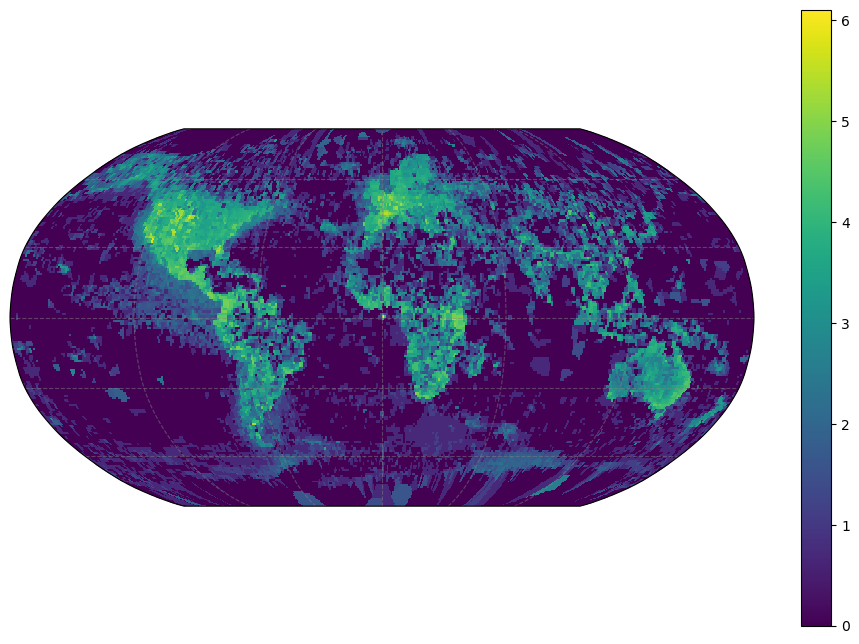

In [16]:
# plot resulting raster on global map - obviously this is more sampling bias than biodiversity

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

subplot_kws=dict(projection=ccrs.Robinson(),
                 facecolor='grey')

plt.figure(figsize=[12,8])
p = geo_grid.logn.plot(cmap='viridis',
                  subplot_kws=subplot_kws,
                  transform=ccrs.PlateCarree(),
                  add_labels=False)

p.axes.gridlines(color='grey', alpha=0.5, linestyle='--')

# zoom in
# p.axes.set_extent([-19, 33, 30, 66], crs=ccrs.PlateCarree())
